In [108]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier

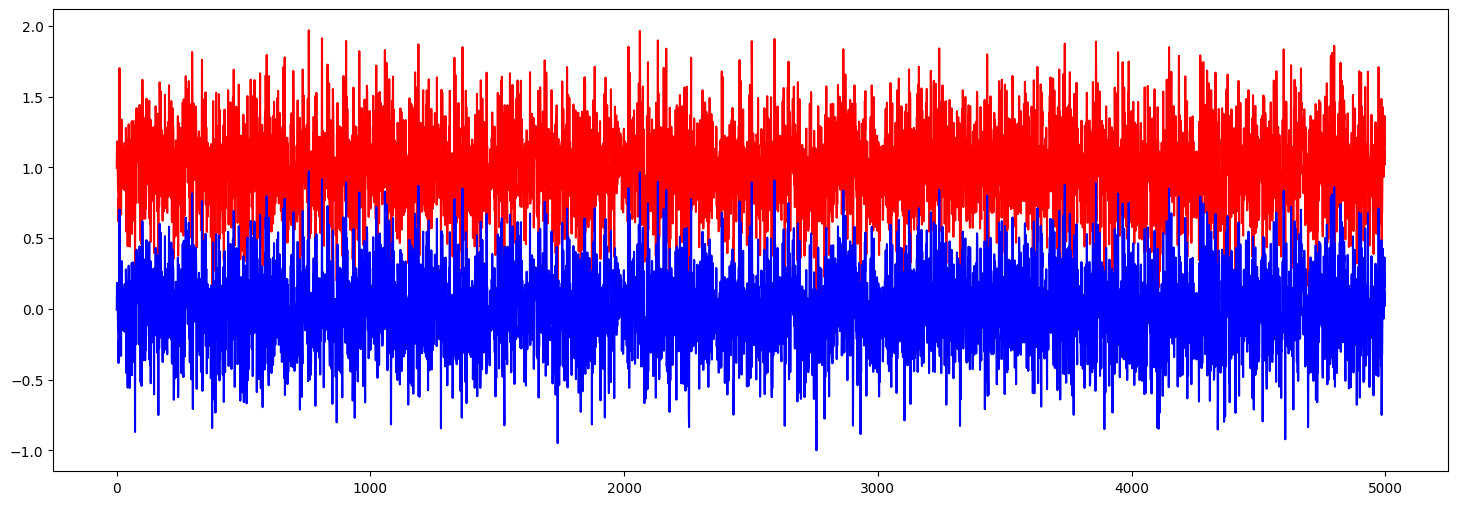

In [109]:
simbolo_0 = 0
simbolo_1 = 1
σ2 = 0.3
N=5000
noise = np.random.normal(0, σ2, N)
a1 = simbolo_1 + noise
a0 = simbolo_0 + noise
plt.figure(figsize=(18,6))
plt.plot(a1,'r')
plt.plot(a0,'b')
plt.show()

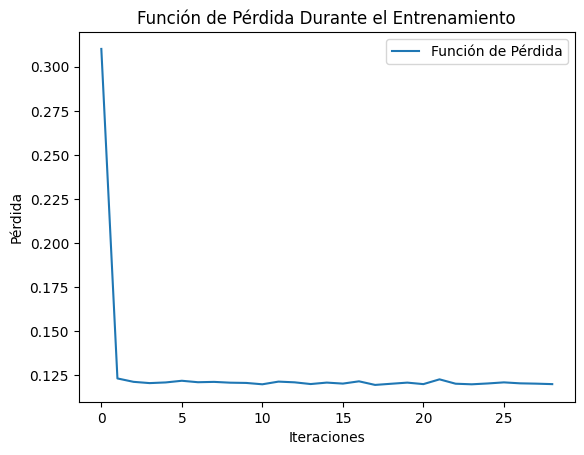

In [110]:
# Preparación de los datos
X = np.concatenate((a0, a1)).reshape(-1, 1)  # Combina a0 y a1 en una sola matriz
y = np.array([0]*N + [1]*N)  # Etiquetas: 0 para a0, 1 para a1

# Creación y entrenamiento del clasificador MLP
clf = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(1000, 50), random_state=1)
clf.fit(X, y)

def procesar_predicciones(predicciones, Nsamples):
    predicciones_ = np.array(np.split(predicciones, len(predicciones) // Nsamples))
    predicciones_ = np.mean(predicciones_, axis=1)
    predicciones_ = np.where(predicciones_ >= 0.5, 1, 0)
    return np.repeat(predicciones_, Nsamples)


# Obtener la función de pérdida
loss_values = clf.loss_curve_
# Crear el gráfico
plt.plot(loss_values, label='Función de Pérdida')
plt.title('Función de Pérdida Durante el Entrenamiento')
plt.xlabel('Iteraciones')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

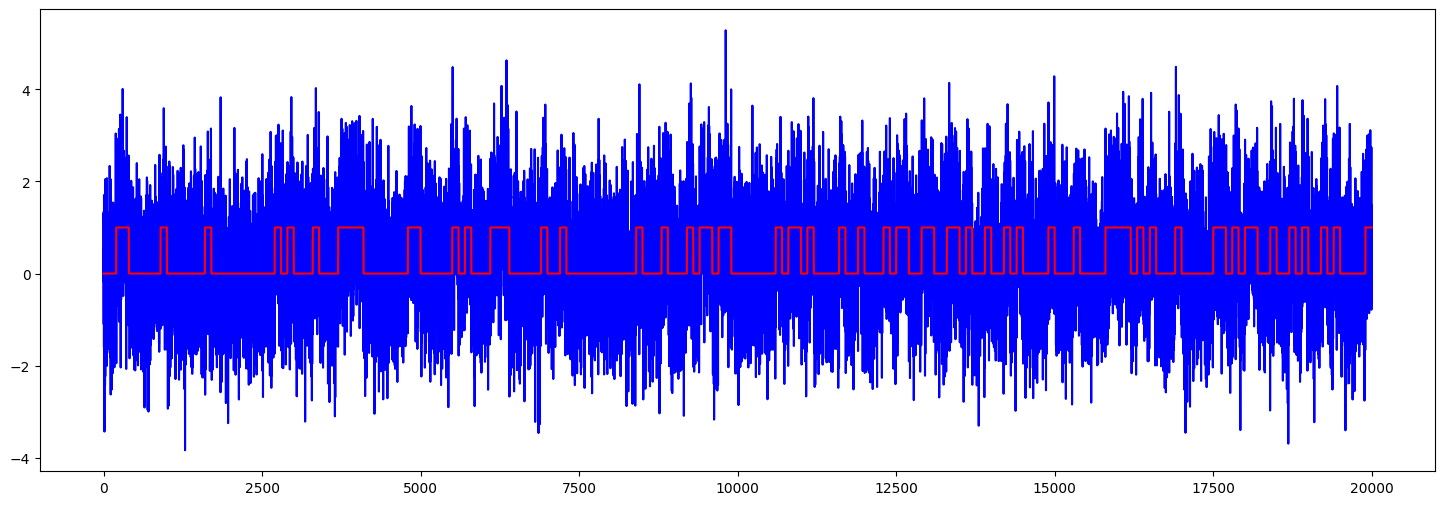

In [111]:
# Generación de datos simbólicos
a1 = 1
a0 = 0
Nsamples =100
p_0 = 0.7
p_1 = 1 - p_0
Nsymbols = 200
N = Nsymbols * Nsamples

# Generar datos
data = np.random.choice([a0, a1], size=Nsymbols, p=[p_0, p_1])
data = np.concatenate([[v]*Nsamples for v in data])
message = data

σ2 = 1
noise = np.random.normal(0, σ2, N)
messageNoise = message + noise

plt.figure(figsize=(18, 6))
plt.plot(messageNoise,'b')
plt.plot(message,'r')

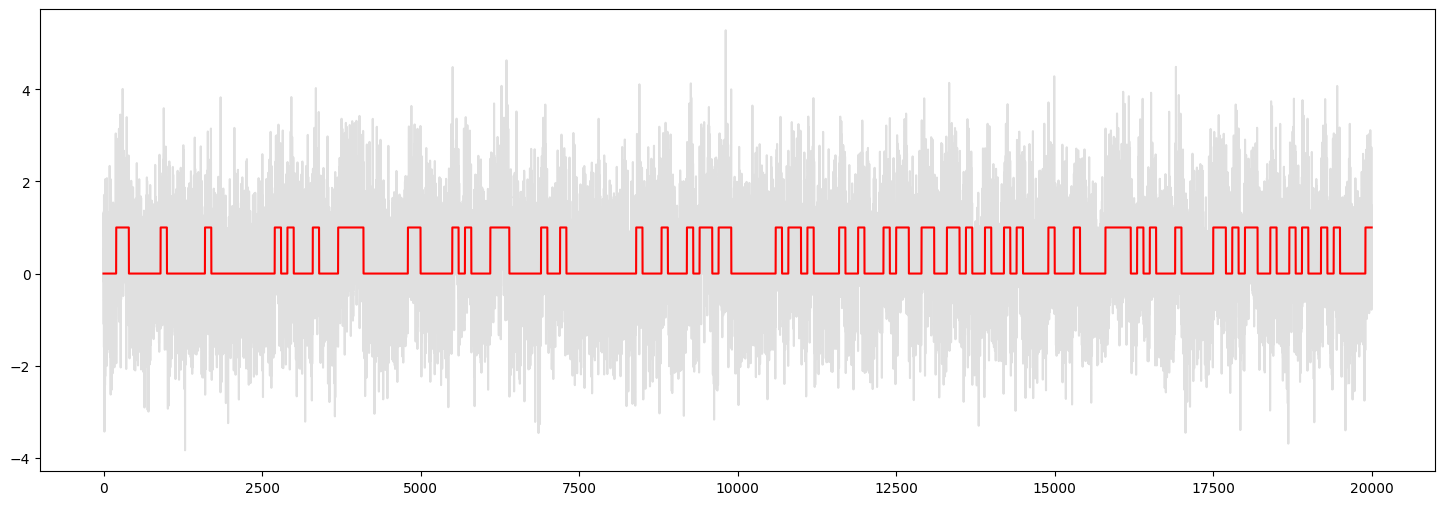

In [112]:
# Probar con ejemplos específicos
predicciones = clf.predict(np.array(messageNoise).reshape(-1, 1))

# Procesar y visualizar predicciones
predicciones_= procesar_predicciones(predicciones, Nsamples)

# Visualización
plt.figure(figsize=(18, 6))
plt.plot(messageNoise, color='#E0E0E0')
plt.plot(predicciones_, 'r')
plt.show()


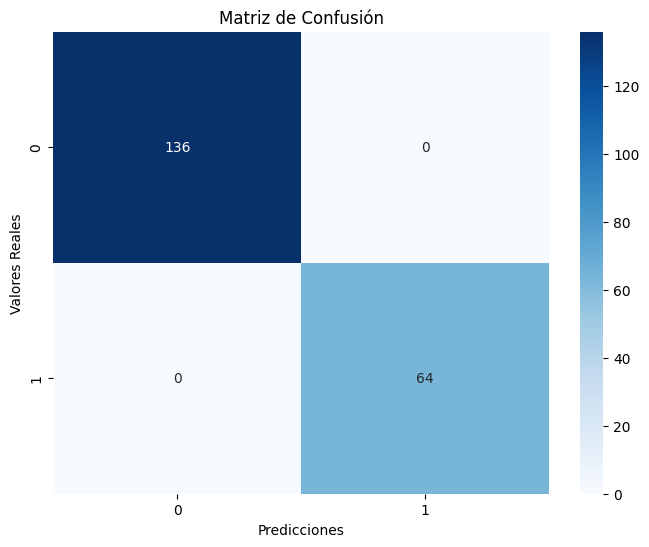

In [113]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf_matrix = confusion_matrix(message, predicciones_)/Nsamples

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.title('Matriz de Confusión')
plt.xlabel('Predicciones')
plt.ylabel('Valores Reales')
plt.show()

## PUNTO 2


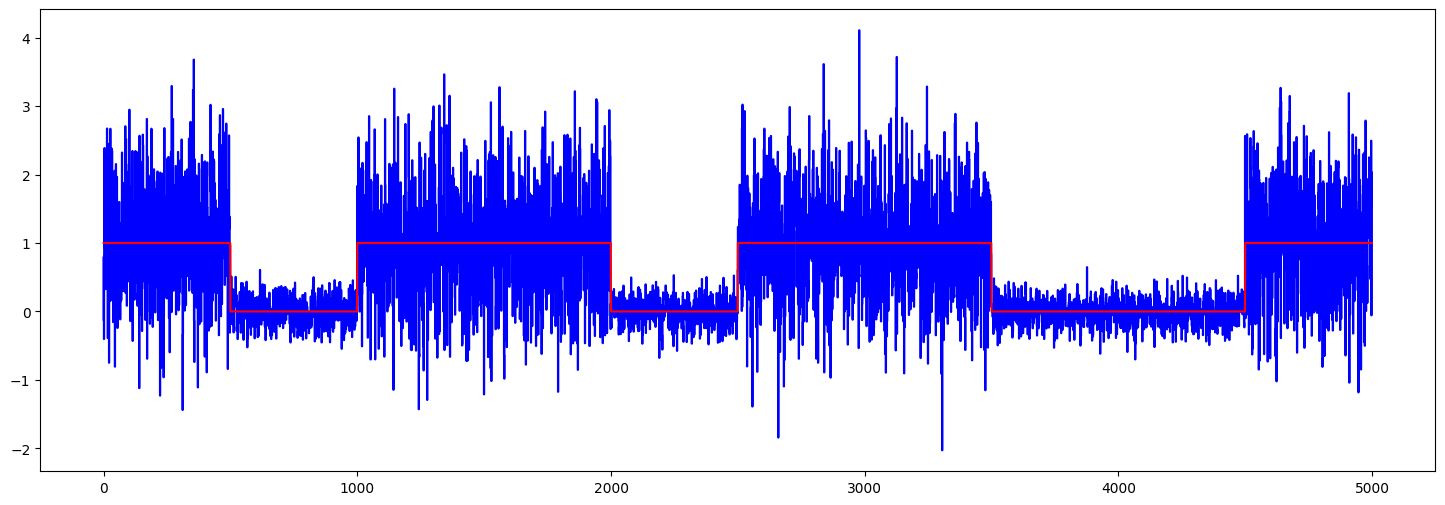

In [114]:
import numpy as np

# Parámetros
a1 = 1
a0 = 0
Nsamples2 = 500
p_0 = 0.5
p_1 = 1 - p_0
Nsymbols = 10
N = Nsymbols * Nsamples2

# Parámetros de ruido
σ2_a0 = 0.2
#noise_a0=np.random.normal(0, σ2_a0, Nsamples)
σ2_a1 = 0.8
#noise_a1 = np.random.normal(0, σ2_a1, Nsamples)

# Generación de datos simbólicos
data = np.random.choice([a0, a1], size=Nsymbols, p=[p_0, p_1])
data1 = np.concatenate([[v]*Nsamples2 for v in data])
message = data1

# Generar el ruido para cada símbolo y sumarlo
noisy_data = []
for symbol in data:
    if symbol == a0:
        noise_a0=np.random.normal(0, σ2_a0, Nsamples2)
        data1 = np.concatenate([[symbol]*Nsamples2])
        noisy_symbol = data1 + noise_a0
        noisy_data.append(noisy_symbol)
    else:
        noise_a1 = np.random.normal(0, σ2_a1, Nsamples2)
        data1 = np.concatenate([[symbol]*Nsamples2])
        noisy_symbol = data1 + noise_a1
        noisy_data.append(noisy_symbol)


# Convertir la lista en un array de numpy y aplanarlo
noisy_data = np.array(noisy_data).flatten()

# Ahora noisy_data contiene los símbolos con su respectivo ruido


plt.figure(figsize=(18, 6))
plt.step(noisy_data,'b')
plt.plot(message,'r')
plt.show()

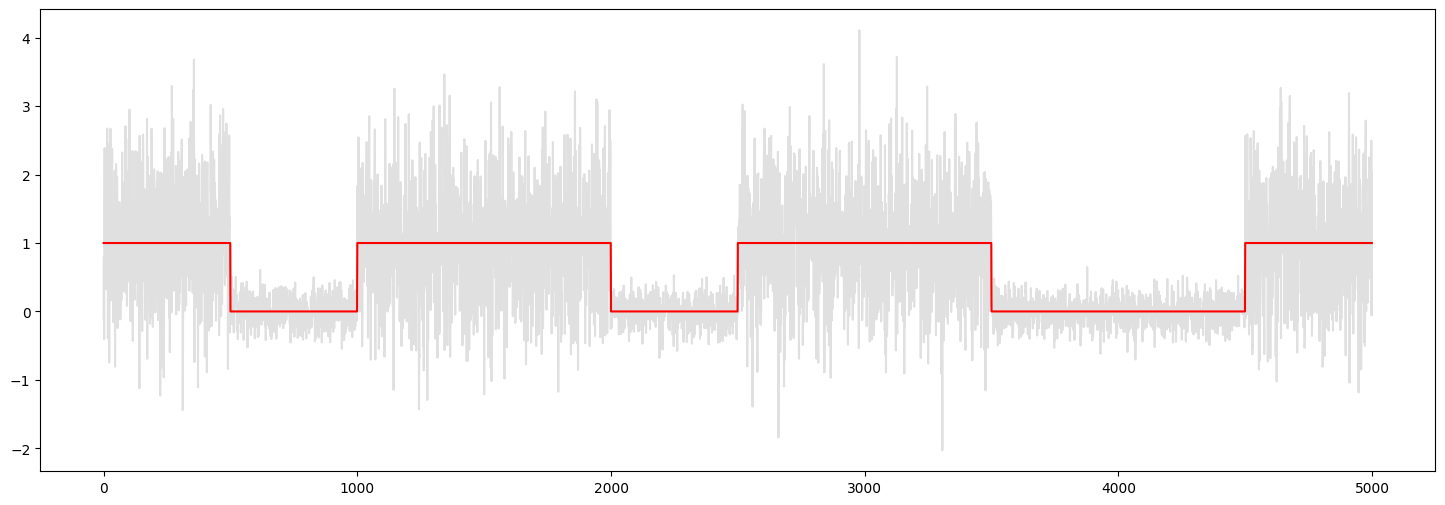

In [115]:
# Probar con ejemplos específicos
predicciones = clf.predict(np.array(noisy_data).reshape(-1, 1))
# Procesar y visualizar predicciones
predicciones_= procesar_predicciones(predicciones, Nsamples2)

# Visualización
plt.figure(figsize=(18, 6))
plt.plot(noisy_data, color='#E0E0E0')
plt.plot(predicciones_, 'r')
plt.show()

## punto 3